### CIFAKE: Real and AI-Generated Synthetic Images

For the RDAI: Foundations of Deep Learning Project, I would like to explore how well deep learning models can differentiate between real and AI-Generated Synthetic Images.

The dataset was obtained from Kaggle: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/data 

The dataset contains 60,000 synthetically-generated images and 60,000 real images (collected from CIFAR-10). The CIFAR-10 is a dataset consisting of 60,000 32x32 colour images, in 10 classes (6000 images per class). In the CIFAR-10 dataset, there are 50,000 training images and 10,000 testing images.
<br><br>

The two classes in this dataset are - REAL and FAKE:
* The REAL images are obtained from the CIFAR-10 dataset. 
* The FAKE images are generated from the equivalent images of CIFAR-10 with Stable Diffusion version 1.4

Hence, there are a total of 100,000 images for training and 20,000 images for testing.
<br><br>


For the purpose of this project, I will be working on a subset of the dataset due to its large dataset.

In [1]:
# Imports
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

In [24]:
import tensorflow as tf
import keras
from keras.models import Model,load_model,Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, Callback, ReduceLROnPlateau, LearningRateScheduler, EarlyStopping, TensorBoard
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
from keras.preprocessing import image
from sklearn.utils import shuffle

### Read data

I will be using only 10% of the total dataset. Hence, the breakdown of the dataset would be:
* Number of Training images: 10,000 (~about 1000 images per class)
    * Fake images: 5000
    * Real images: 5000
* Number of Testing images: 2000 (~about 200 images per class)
    * Fake images: 1000
    * Real images: 1000

In [3]:
train_dir = 'C:/Users/chuax/Desktop/DSTA/RDAI/Project/archive/train'
test_dir = 'C:/Users/chuax/Desktop/DSTA/RDAI/Project/archive/test'
labels = ['FAKE', 'REAL']

random.seed(42)

train_fake_files = os.listdir(f'{train_dir}/FAKE')
random.shuffle(train_fake_files)
train_fake_files = train_fake_files[:int(len(train_fake_files)/100 * 10)]

train_real_files = os.listdir(f'{train_dir}/REAL')
random.shuffle(train_real_files)
train_real_files = train_real_files[:int(len(train_real_files)/100 * 10)]

test_fake_files = os.listdir(f'{test_dir}/FAKE')
random.shuffle(test_fake_files)
test_fake_files = test_fake_files[:int(len(test_fake_files)/100 * 10)]

test_real_files = os.listdir(f'{test_dir}/REAL')
random.shuffle(test_real_files)
test_real_files = test_real_files[:int(len(test_real_files)/100 * 10)]


x_test = []
for files in test_fake_files:
    img = image.load_img(f'{test_dir}/FAKE/{files}', target_size=(32, 32))
    x = image.img_to_array(img)
    x_test.append(x)
for files in test_real_files:
    img = image.load_img(f'{test_dir}/REAL/{files}', target_size=(32, 32))
    x = image.img_to_array(img)
    x_test.append(x)
x_test = np.array(x_test)

y_test = len(test_fake_files)*['FAKE'] + len(test_real_files)*['REAL']
y_test = np.array(y_test)

print(f'x_test shape: {x_test.shape}')
print(f'y_test shape: {y_test.shape}')


x_train = []
for files in train_fake_files:
    img = image.load_img(f'{train_dir}/FAKE/{files}', target_size=(32, 32))
    x = image.img_to_array(img)
    x_train.append(x)
for files in train_real_files:
    img = image.load_img(f'{train_dir}/REAL/{files}', target_size=(32, 32))
    x = image.img_to_array(img)
    x_train.append(x)
x_train = np.array(x_train)

y_train = len(train_fake_files)*['FAKE'] + len(train_real_files)*['REAL']
y_train = np.array(y_train)

print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')

x_test shape: (2000, 32, 32, 3)
y_test shape: (2000,)
x_train shape: (10000, 32, 32, 3)
y_train shape: (10000,)


### Data Exploration

Taking a look at how the real and fake images look like!

It seems like the Fake and Real images look pretty similar.

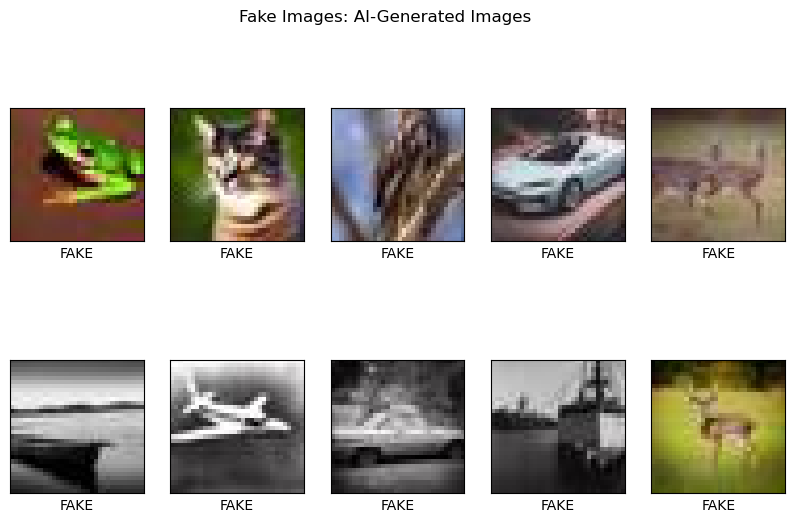

In [4]:
# Normalize pixel values to be between 0 and 1
x_train_normalize, x_test_normalize = x_train / 255.0, x_test / 255.0

fig, ax = plt.subplots(2,5, figsize=(10,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_normalize[i])
    plt.xlabel(y_train[i])
fig.suptitle('Fake Images: AI-Generated Images')
plt.show()

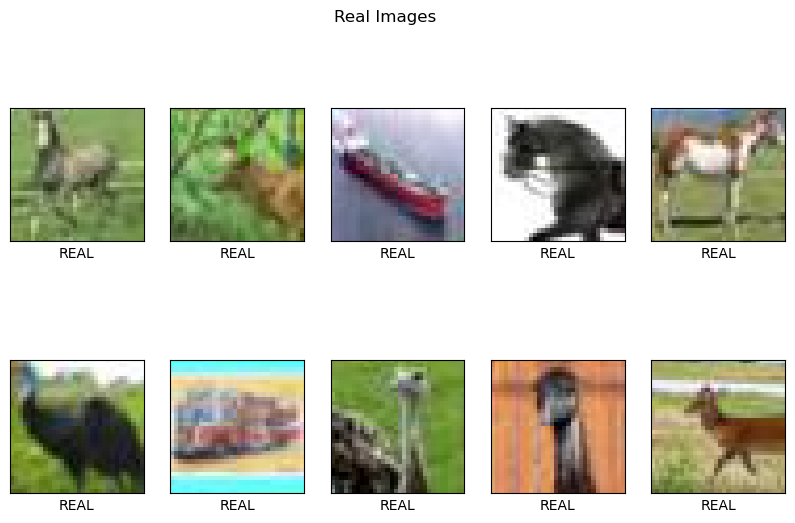

In [5]:
fig, ax = plt.subplots(2,5, figsize=(10,6))
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_normalize[-i])
    plt.xlabel(y_train[-i])
fig.suptitle('Real Images')
plt.show()

### Split the training set into training and validation

Training would consists of 90% of the training dataset, and validation would consists of the remaining 10%.

In [6]:
label_mapping = {'FAKE': 0, 'REAL': 1}
y_test = np.array([label_mapping[label] for label in y_test])
y_train = np.array([label_mapping[label] for label in y_train])

In [7]:
# Shuffle training set
x_train_normalize, y_train = shuffle(x_train_normalize, y_train, random_state=42)

# Split training into train (90%) and validation set (10%)
split = int(0.9 * len(x_train_normalize))
x_train_normalize_2, x_val_normalize = x_train_normalize[:split,:], x_train_normalize[split:,:]
y_train_2, y_val = y_train[:split], y_train[split:]

In [8]:
print(f'x_train_normalize_2 shape: {x_train_normalize_2.shape}')
print(f'y_train_2 shape: {y_train_2.shape}')
print(f'x_val_normalize shape: {x_val_normalize.shape}')
print(f'y_val shape: {y_val.shape}')

x_train_normalize_2 shape: (9000, 32, 32, 3)
y_train_2 shape: (9000,)
x_val_normalize shape: (1000, 32, 32, 3)
y_val shape: (1000,)


### Data preparation

In [12]:
img_rows, img_cols = 32,32
batch_size = 32
num_classes = 2

def _parse_function(img, label):
    image_resized = tf.ensure_shape(img ,shape=(img_rows, img_cols,3))
    label = tf.one_hot(label, num_classes)
    return image_resized, label

In [13]:
# create a tf dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_normalize_2, y_train_2))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val_normalize, y_val))
val_dataset = val_dataset.map(_parse_function)
val_dataset = val_dataset.batch(batch_size, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test_normalize, y_test))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.batch(batch_size, drop_remainder=True)

In [14]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 2), dtype=tf.float32, name=None))>

In [15]:
val_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 2), dtype=tf.float32, name=None))>

In [16]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 2), dtype=tf.float32, name=None))>

### Model 1: A simple CNN Model

Trying out just a simple CNN model first!

In [25]:
Inp = Input(shape=(32,32,3))
x = Conv2D(32, kernel_size=(3,3), activation='relu', name='Conv_01')(Inp)
x = MaxPooling2D(pool_size=(2, 2),name = 'MaxPool_01')(x)
x = Conv2D(64, (3, 3), activation='relu',name = 'Conv_02')(x)
x = MaxPooling2D(pool_size=(2, 2),name = 'MaxPool_02')(x)
x = Conv2D(64, (3, 3), activation='relu',name = 'Conv_03')(x)
x = Flatten(name = 'Flatten_01')(x)
x = Dense(64, activation='relu',name = 'Dense_01')(x)
x = Dropout(0.5,name = 'Dropout_01')(x)
output = Dense(2, activation='softmax',name = 'Dense_02')(x)

model = Model(Inp,output,name='CNN_Model')

In [26]:
model.summary()

Model: "CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_01 (Conv2D)                │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool_01 (MaxPooling2D)       │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_02 (Conv2D)                │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool_02 (MaxPooling2D)       │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_03 (Conv2D)                │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten_01 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_01 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_01 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_02 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,050 (476.76 KB)

 Trainable params: 122,050 (476.76 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
checkpoint_path = 'C:/Users/chuax/Desktop/DSTA/RDAI/Project/checkpoints'
checkpoint = ModelCheckpoint(f'{checkpoint_path}/best_model_1.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=3,verbose=0,mode='auto')

reduce_LR = ReduceLROnPlateau(monitor='val_loss',factor = 0.5, patience=2,cooldown=0, min_lr = 0.00001)

In [30]:
### Train the model with validation
epochs = 100

history = model.fit(train_dataset,
                   epochs = epochs,
                   validation_data = val_dataset,
                   callbacks=[checkpoint, early_stopping, reduce_LR])

Epoch 1/100
275/281 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6511 - loss: 0.6164
Epoch 1: val_accuracy improved from -inf to 0.78931, saving model to C:/Users/chuax/Desktop/DSTA/RDAI/Project/checkpoints/best_model_1.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6527 - loss: 0.6149 - val_accuracy: 0.7893 - val_loss: 0.4724 - learning_rate: 0.0010
Epoch 2/100
275/281 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7892 - loss: 0.4677
Epoch 2: val_accuracy improved from 0.78931 to 0.82359, saving model to C:/Users/chuax/Desktop/DSTA/RDAI/Project/checkpoints/best_model_1.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7893 - loss: 0.4673 - val_accuracy: 0.8236 - val_loss: 0.4037 - learning_rate: 0.0010
Epoch 3/100
276/281 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8217 - loss: 0.4032
Epoch 3: val_accuracy improved from 0.82359 to 0.84778, saving model to C:/Users/chuax/Desktop/DSTA/RDAI/Project/checkpoints/best_model_1.keras
281/281 ━━━━━━━━━━━━━━━━━━━━

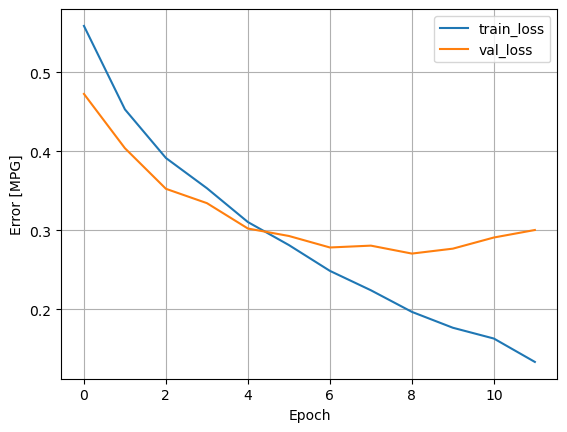

In [31]:
# loss plot
def plot_loss(history):
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

plot_loss(history)

In [32]:
metrics = model.evaluate(test_dataset)
print("model accuracy:",metrics[1])

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8931 - loss: 0.3355
model accuracy: 0.9077621102333069


### Model 2: Pre-trained VGG16 Model

Next, trying a pre-trained VGG16 Model with transfer learning!

In [84]:
# create the base pre-trained model
base_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [85]:
# add a global spatial average pooling layer
x = base_model.output

x = Flatten()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.5)(x)

# and a logits layer 
predictions = Dense(2, activation='softmax')(x)

In [86]:
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,978,370 (57.14 MB)

 Trainable params: 14,978,370 (57.14 MB)

 Non-trainable params: 0 (0.00 B)

In [87]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional VGG16 layers
for layer in base_model.layers:
    # print(layer.name)
    layer.trainable = False
    print(layer.name,' Trainable =',layer.trainable)

input_layer_6  Trainable = False
block1_conv1  Trainable = False
block1_conv2  Trainable = False
block1_pool  Trainable = False
block2_conv1  Trainable = False
block2_conv2  Trainable = False
block2_pool  Trainable = False
block3_conv1  Trainable = False
block3_conv2  Trainable = False
block3_conv3  Trainable = False
block3_pool  Trainable = False
block4_conv1  Trainable = False
block4_conv2  Trainable = False
block4_conv3  Trainable = False
block4_pool  Trainable = False
block5_conv1  Trainable = False
block5_conv2  Trainable = False
block5_conv3  Trainable = False
block5_pool  Trainable = False


In [88]:
for layer in model.layers:
    print(layer.name,' Trainable =',layer.trainable)

input_layer_6  Trainable = False
block1_conv1  Trainable = False
block1_conv2  Trainable = False
block1_pool  Trainable = False
block2_conv1  Trainable = False
block2_conv2  Trainable = False
block2_pool  Trainable = False
block3_conv1  Trainable = False
block3_conv2  Trainable = False
block3_conv3  Trainable = False
block3_pool  Trainable = False
block4_conv1  Trainable = False
block4_conv2  Trainable = False
block4_conv3  Trainable = False
block4_pool  Trainable = False
block5_conv1  Trainable = False
block5_conv2  Trainable = False
block5_conv3  Trainable = False
block5_pool  Trainable = False
flatten_1  Trainable = True
dense_6  Trainable = True
dropout_3  Trainable = True
dense_7  Trainable = True


In [89]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,978,370 (57.14 MB)

 Trainable params: 263,682 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [90]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [91]:
checkpoint_path = 'C:/Users/chuax/Desktop/DSTA/RDAI/Project/checkpoints'
checkpoint = ModelCheckpoint(f'{checkpoint_path}/best_model_2.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=3,verbose=0,mode='auto')

reduce_LR = ReduceLROnPlateau(monitor='val_loss',factor = 0.5, patience=2,cooldown=0, min_lr = 0.00001)

In [92]:
### Train the model with validation
epochs = 100

history = model.fit(train_dataset,
                   epochs = epochs,
                   validation_data = val_dataset,
                   callbacks=[checkpoint, early_stopping, reduce_LR])

Epoch 1/100
280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7169 - loss: 0.5488
Epoch 1: val_accuracy improved from -inf to 0.77319, saving model to C:/Users/chuax/Desktop/DSTA/RDAI/Project/checkpoints/best_model_2.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.7173 - loss: 0.5484 - val_accuracy: 0.7732 - val_loss: 0.4564 - learning_rate: 0.0010
Epoch 2/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8026 - loss: 0.4210
Epoch 2: val_accuracy improved from 0.77319 to 0.81250, saving model to C:/Users/chuax/Desktop/DSTA/RDAI/Project/checkpoints/best_model_2.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - accuracy: 0.8026 - loss: 0.4209 - val_accuracy: 0.8125 - val_loss: 0.4106 - learning_rate: 0.0010
Epoch 3/100
280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8268 - loss: 0.3894
Epoch 3: val_accuracy did not improve from 0.81250
281/281 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - accuracy: 0.8268 - loss: 0.3894 - val_accuracy: 0.8054 - val_loss: 0.

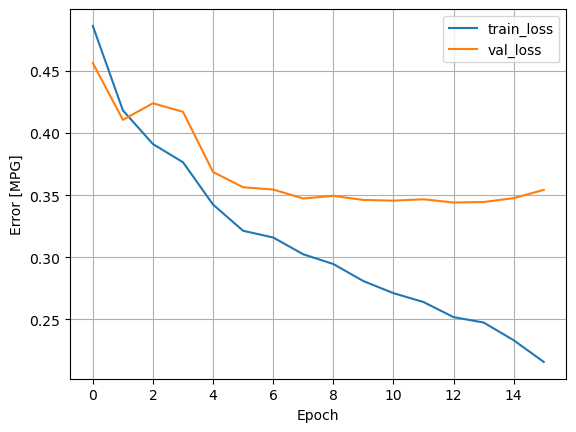

In [93]:
# loss plot
def plot_loss(history):
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

plot_loss(history)

In [94]:
metrics = model.evaluate(test_dataset)
print("model accuracy:",metrics[1])

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8774 - loss: 0.3031
model accuracy: 0.8467742204666138


### Conclusion

The simple CNN model was able to achieve a test accuracy of 90.8%. However, the pre-trained VGG16 model achieved a test accuracy of 84.7%. 

Both models has done decently well in categorising whether an image is real or fake. But, it was rather unexpected for the simple CNN model to do better than the pre-trained VGG16 model.